In [1]:
import sys
sys.path.append('../')
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences
from sklearn.linear_model import LinearRegression
import Utils.graphing_helpers
import read_data as rd
import importlib
importlib.reload(Utils.graphing_helpers)
from Utils.graphing_helpers import (plot_vicsek_phase_diagram, plot_dir_cross_vel_phase_diagram,  plot_dir_cross_vel_norm_phase_diagram, 
                                    save_fig_pdf, edges_from_centers_log, edges_from_centers_linear)
from Analysis_Calculations.local_packing_fraction import get_local_packing_fraction, get_peaks_info

# All Densities

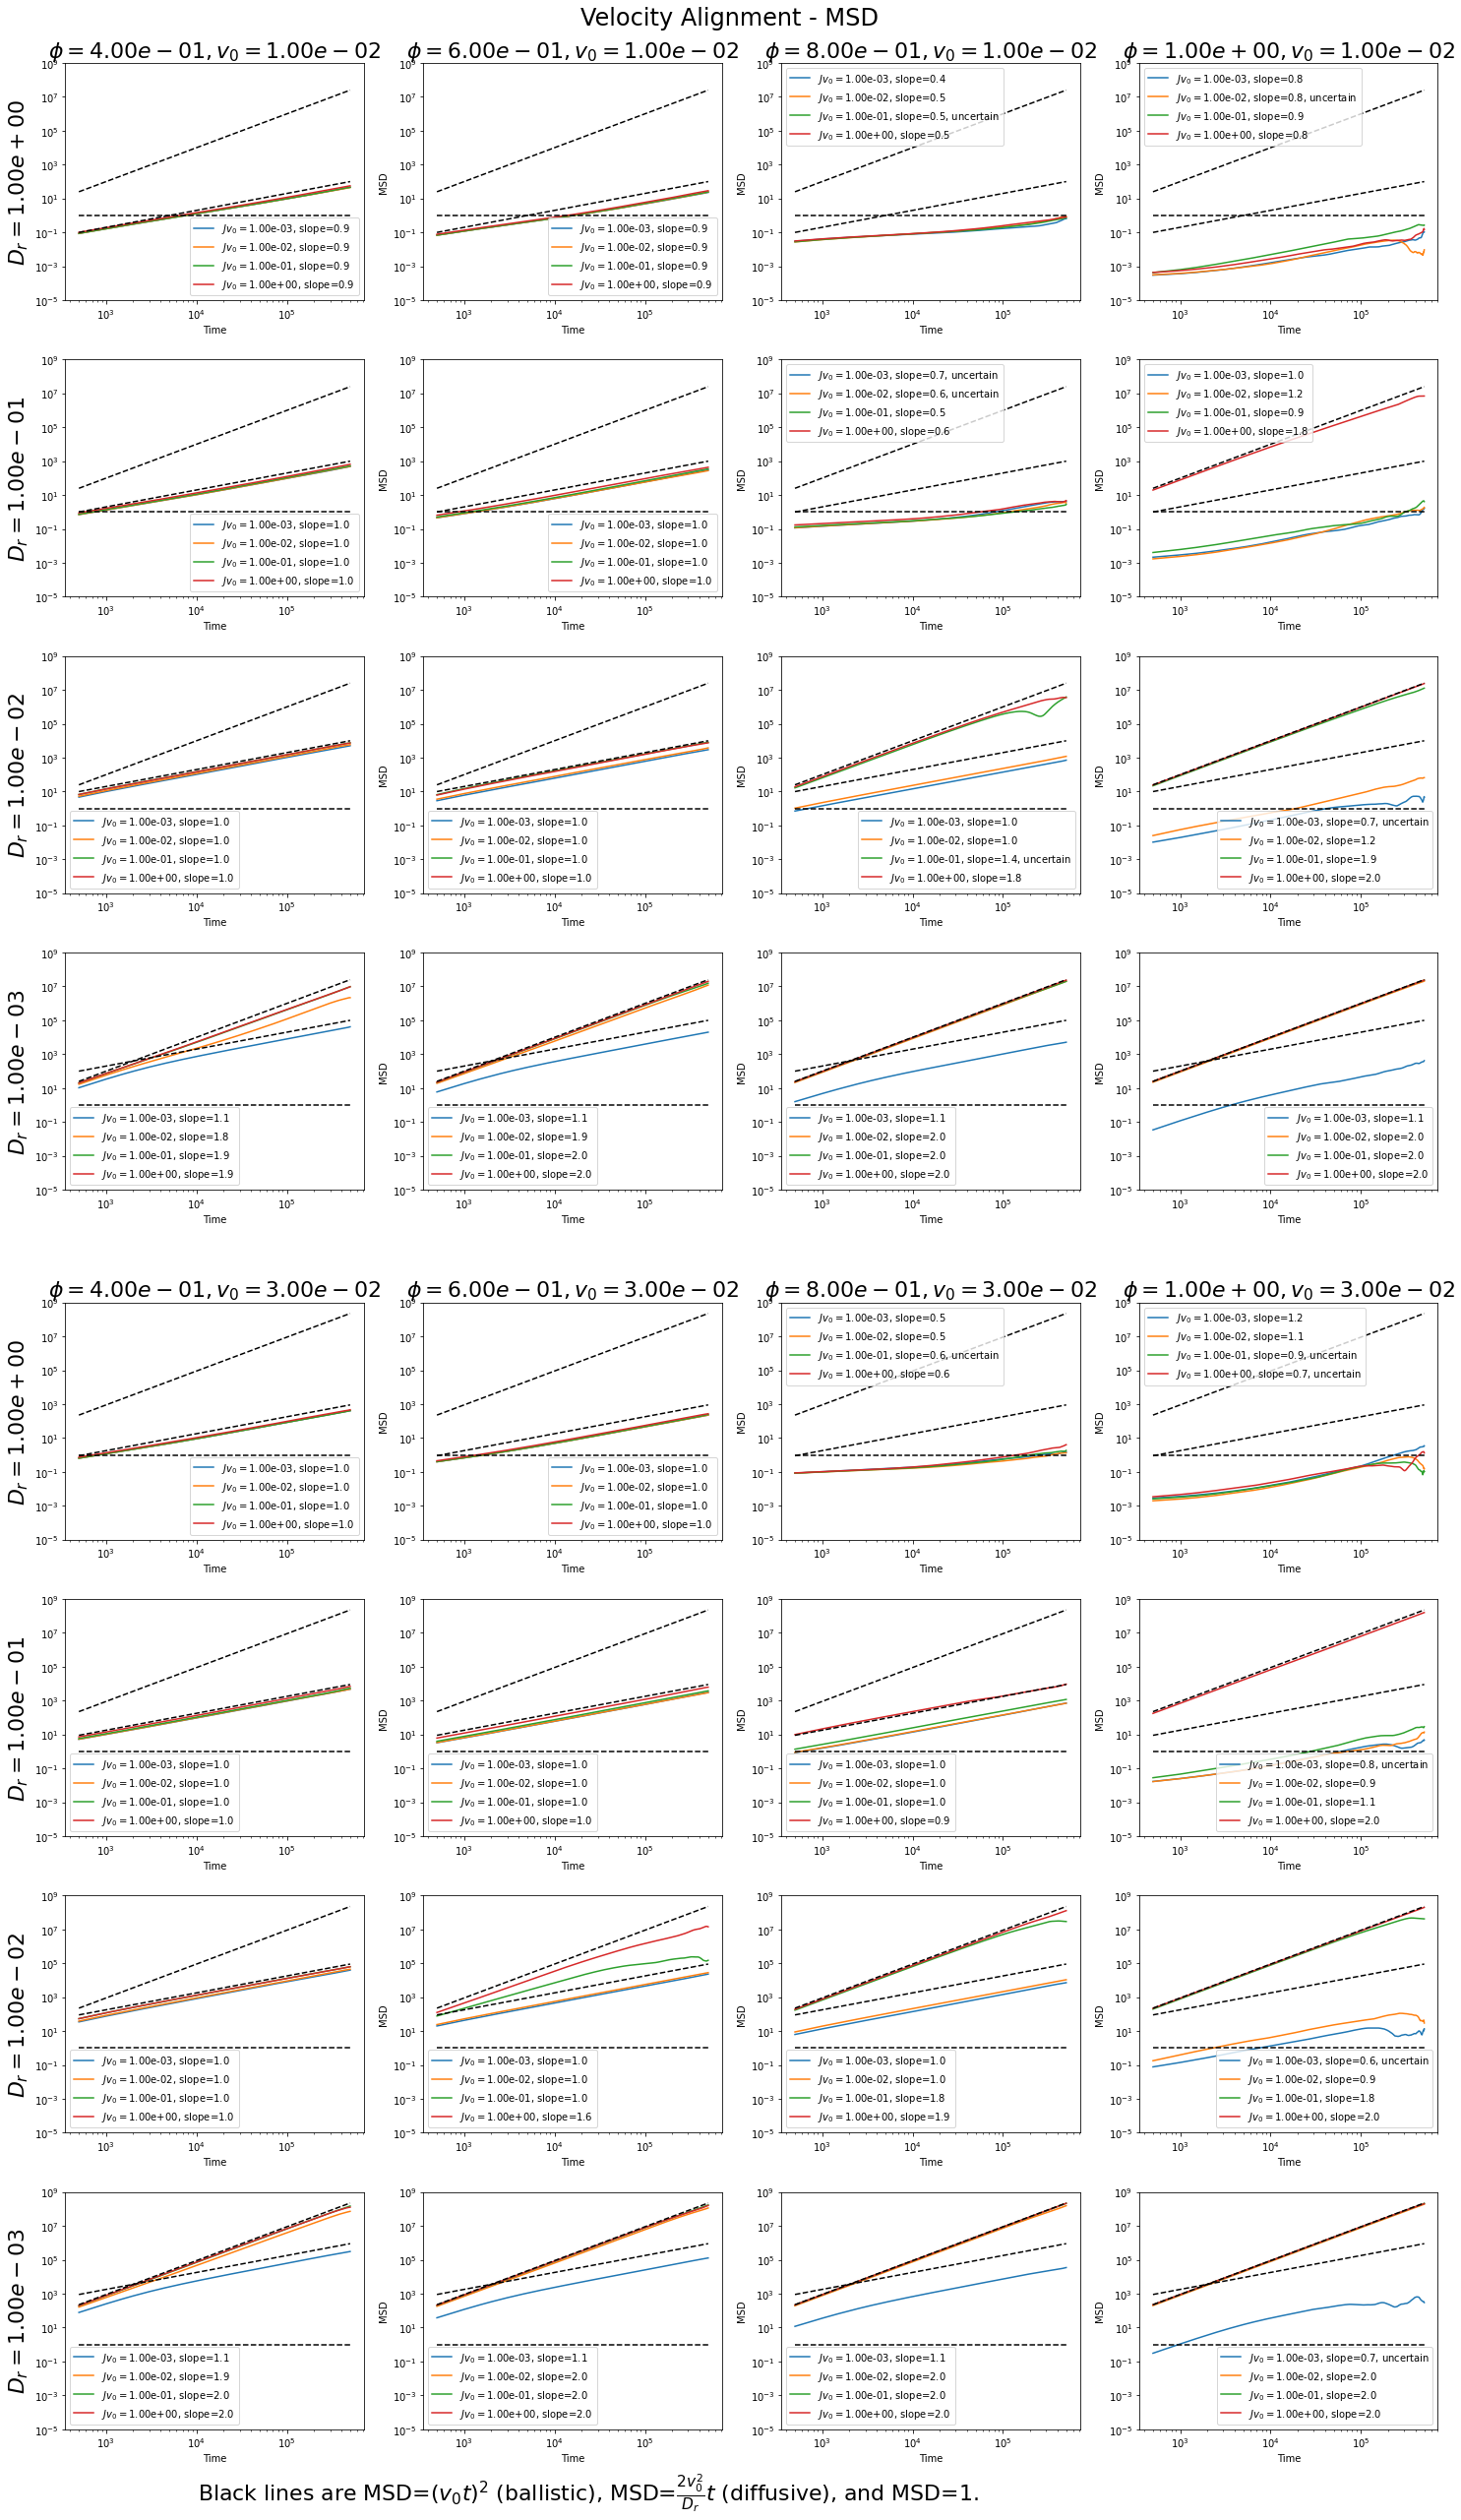

In [7]:
times = np.linspace(0, 5e5, num=1000)[1:]
save_dir = "/home/ryanlopez/Velocity_Align_Vary_Phi_V_Saved_Data2"

phi_vals = [0.4, 0.6, 0.8, 1]
v0_vals = [0.01, 0.03]
Jv_vals = np.logspace(-3, 0, num=4)
Dr_vals = np.logspace(-3, 0, num=4)

fig = plt.figure(figsize=(25, 40))
outer_grid = fig.add_gridspec(len(v0_vals), len(phi_vals), wspace=0.2, hspace=0.1)

for phi_index, phi in enumerate(phi_vals):
    for v0_index, v0 in enumerate(v0_vals):
        # gridspec inside gridspec
        inner_grid = outer_grid[v0_index, phi_index].subgridspec(len(Dr_vals), 1, wspace=0.25, hspace=0.25)
        axs = inner_grid.subplots()  # Create all subplots for the inner grid.
        for Dr_index, Dr in enumerate(Dr_vals):
            for J_index, Jv in enumerate(Jv_vals):
                J=Jv/v0
                exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0)
                run_folder_name = "J=%.4f_and_Dr=%.4f"%(J, Dr)
                analysis_data_dir = os.path.join(save_dir, exp_folder_name, run_folder_name, 'analysis_data')
                msd_normal_filename = os.path.join(analysis_data_dir, 'msd_normal.npy')
                #Plot MSD
                with open(msd_normal_filename, 'rb') as msd_normal_file:
                    msd_normal = np.load(msd_normal_file)
                linear_model = LinearRegression().fit(np.log(times)[:,None], np.log(msd_normal)[:,None], sample_weight = np.arange(len(times), 0, -1)**2)
                label = rf'$Jv_0=${Jv:.2e}, slope={linear_model.coef_.item():.1f}'
                if linear_model.score(np.log(times)[:,None], np.log(msd_normal)[:,None], sample_weight = np.arange(len(times), 0, -1)**2) < 0.95:
                    label += ', uncertain'
                axs[-Dr_index-1].plot(times, msd_normal, label=label)
            #Plot slope 1 line
            slope_1_line = 2*(v0**2 / Dr)*times
            axs[-Dr_index-1].plot(times, slope_1_line, color='black', linestyle='--')
            #Plot slope 2 line
            slope_2_line = v0**2 * times**2
            axs[-Dr_index-1].plot(times, slope_2_line, color='black', linestyle='--')
            #Plot MSD = 1 cutoff
            axs[-Dr_index-1].plot(times, np.full_like(times, 1), color='black', linestyle='--')
            axs[-Dr_index-1].set_xlabel('Time')
            axs[-Dr_index-1].set_xscale('log')
            axs[-Dr_index-1].set_yscale('log')
            axs[-Dr_index-1].set_ylim(1e-5, 1e9)
            if Dr_index == len(Dr_vals)-1:
                axs[-Dr_index-1].set_title(rf'$\phi = {phi:.2e}, v_0 = {v0:.2e}$', fontsize=22)
            if phi_index == 0:
                axs[-Dr_index-1].set_ylabel(rf'$D_r = {Dr:.2e}$', fontsize=22)
            else:
                axs[-Dr_index-1].set_ylabel('MSD')
            axs[-Dr_index-1].legend()
fig.suptitle(rf'Velocity Alignment - MSD', fontsize = 24)
plt.subplots_adjust(top=0.96)
plt.text(0.2, 0.1, r'Black lines are MSD=$(v_0 t)^2$ (ballistic), MSD=$\frac{2v_0^2}{D_r}t$ (diffusive), and MSD=1.', fontsize=22, transform=plt.gcf().transFigure)
save_fig_pdf(os.path.join(save_dir, 'phase_diagrams', 'normal_msd.pdf'))
plt.show()

# Only High Density

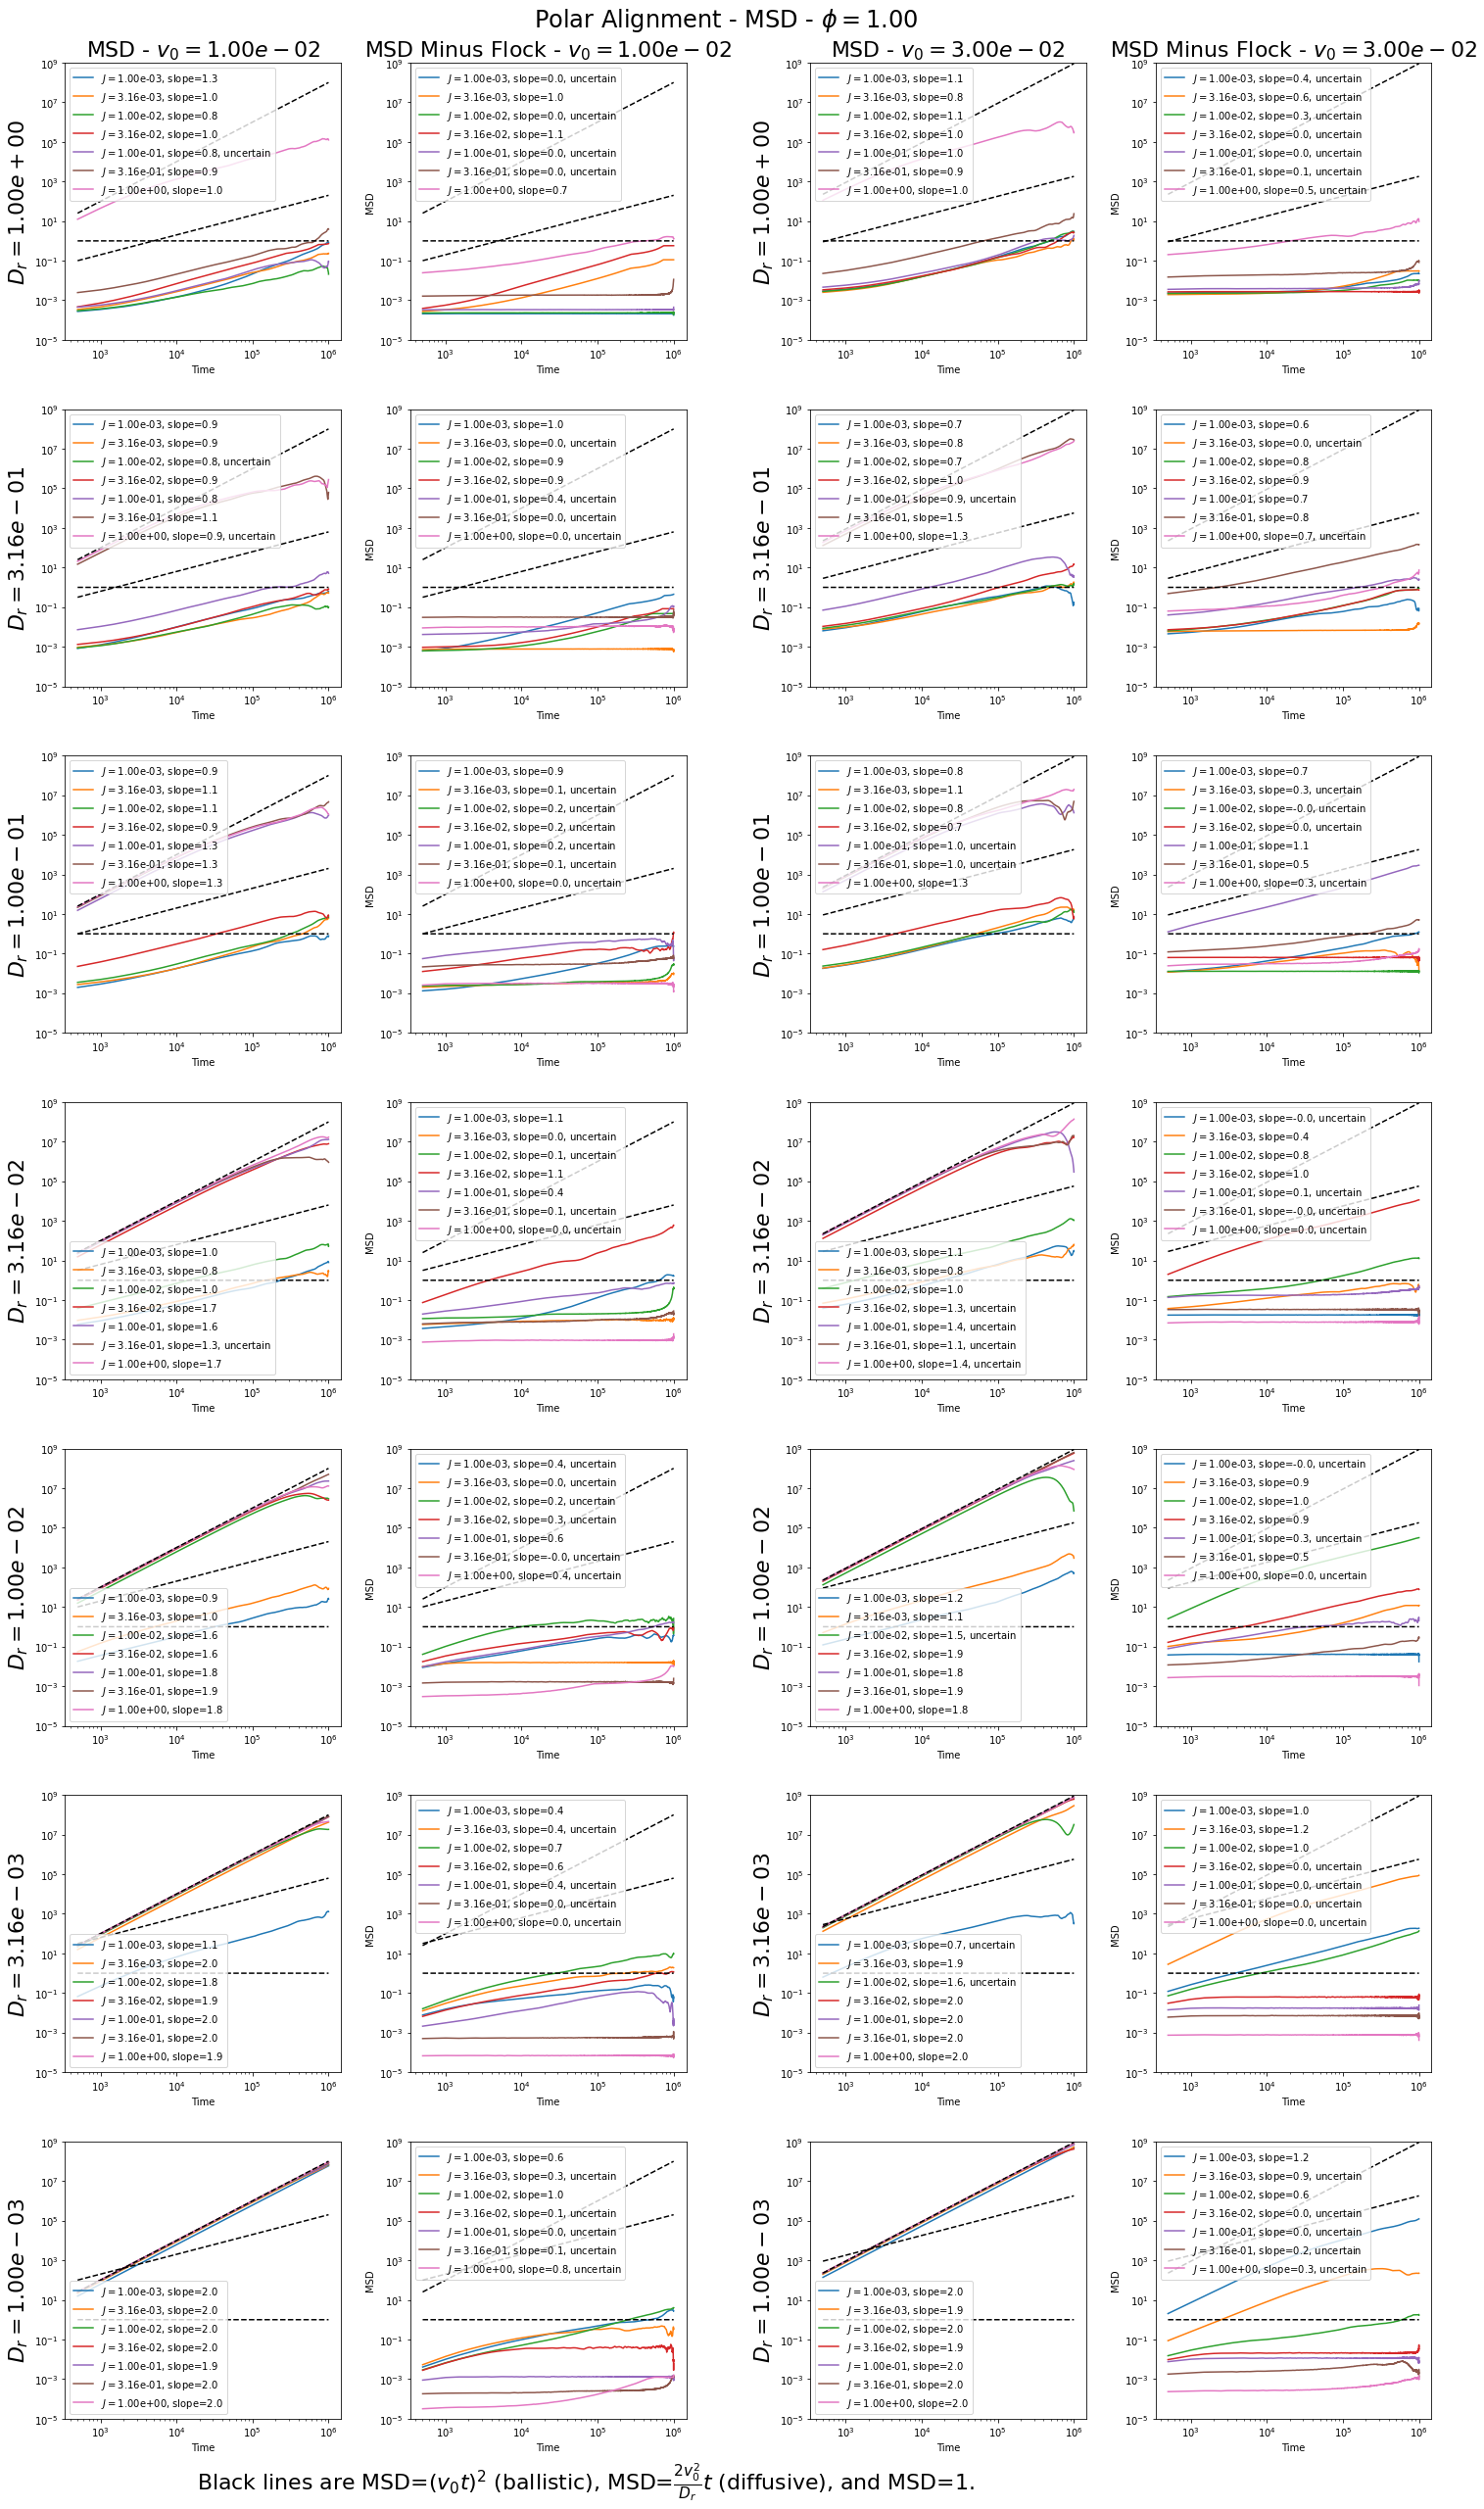

In [28]:
times = np.linspace(0, 1e6, num=2000)[1:]
save_dir = "/home/ryanlopez/Polar_Align_Vary_Phi_V_Saved_Data2"

phi = 1.0
v0_vals = [0.01, 0.03]
J_vals = np.logspace(-3, 0, num=7)
Dr_vals = np.logspace(-3, 0, num=7)
msd_types = ['normal', 'normal_minus_avg']

fig = plt.figure(figsize=(25, 40))
outer_grid = fig.add_gridspec(1, len(v0_vals), wspace=0.2, hspace=0.1)

for v0_index, v0 in enumerate(v0_vals):
    # gridspec inside gridspec
    inner_grid = outer_grid[v0_index].subgridspec(len(Dr_vals), 2, wspace=0.25, hspace=0.25)
    axs = inner_grid.subplots()  # Create all subplots for the inner grid.
    for msd_index, msd_type in enumerate(msd_types):
        for Dr_index, Dr in enumerate(Dr_vals):
            for J_index, J in enumerate(J_vals):
                exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0)
                run_folder_name = "J=%.4f_and_Dr=%.4f"%(J, Dr)
                analysis_data_dir = os.path.join(save_dir, exp_folder_name, run_folder_name, 'analysis_data')
                if msd_index == 0:
                    msd_normal_filename = os.path.join(analysis_data_dir, 'msd_normal.npy')
                elif msd_index == 1:
                    msd_normal_filename = os.path.join(analysis_data_dir, 'msd_normal_minus_avg.npy')
                #Plot MSD
                with open(msd_normal_filename, 'rb') as msd_normal_file:
                    msd_normal = np.load(msd_normal_file)
                linear_model = LinearRegression().fit(np.log(times)[:,None], np.log(msd_normal)[:,None], sample_weight = np.arange(len(times), 0, -1)**2)
                label = rf'$J=${J:.2e}, slope={linear_model.coef_.item():.1f}'
                if linear_model.score(np.log(times)[:,None], np.log(msd_normal)[:,None], sample_weight = np.arange(len(times), 0, -1)**2) < 0.95:
                    label += ', uncertain'
                axs[-Dr_index-1, msd_index].plot(times, msd_normal, label=label)
            #Plot slope 1 line
            slope_1_line = 2*(v0**2 / Dr)*times
            axs[-Dr_index-1, msd_index].plot(times, slope_1_line, color='black', linestyle='--')
            #Plot slope 2 line
            slope_2_line = v0**2 * times**2
            axs[-Dr_index-1, msd_index].plot(times, slope_2_line, color='black', linestyle='--')
            #Plot MSD = 1 cutoff
            axs[-Dr_index-1, msd_index].plot(times, np.full_like(times, 1), color='black', linestyle='--')
            axs[-Dr_index-1, msd_index].set_xlabel('Time')
            axs[-Dr_index-1, msd_index].set_xscale('log')
            axs[-Dr_index-1, msd_index].set_yscale('log')
            axs[-Dr_index-1, msd_index].set_ylim(1e-5, 1e9)
            if Dr_index == len(Dr_vals)-1:
                if msd_index == 0:
                    axs[-Dr_index-1, msd_index].set_title(rf'MSD - $v_0 = {v0:.2e}$', fontsize=22)
                elif msd_index == 1:
                    axs[-Dr_index-1, msd_index].set_title(rf'MSD Minus Flock - $v_0 = {v0:.2e}$', fontsize=22)
            if msd_index == 0:
                axs[-Dr_index-1, msd_index].set_ylabel(rf'$D_r = {Dr:.2e}$', fontsize=22)
            else:
                axs[-Dr_index-1, msd_index].set_ylabel('MSD')
            axs[-Dr_index-1, msd_index].legend()
fig.suptitle(rf'Polar Alignment - MSD - $\phi={phi:.2f}$', fontsize = 24)
plt.subplots_adjust(top=0.96)
plt.text(0.2, 0.1, r'Black lines are MSD=$(v_0 t)^2$ (ballistic), MSD=$\frac{2v_0^2}{D_r}t$ (diffusive), and MSD=1.', fontsize=22, transform=plt.gcf().transFigure)
save_fig_pdf(os.path.join(save_dir, 'phase_diagrams', 'high_density_msd.pdf'))
plt.show()

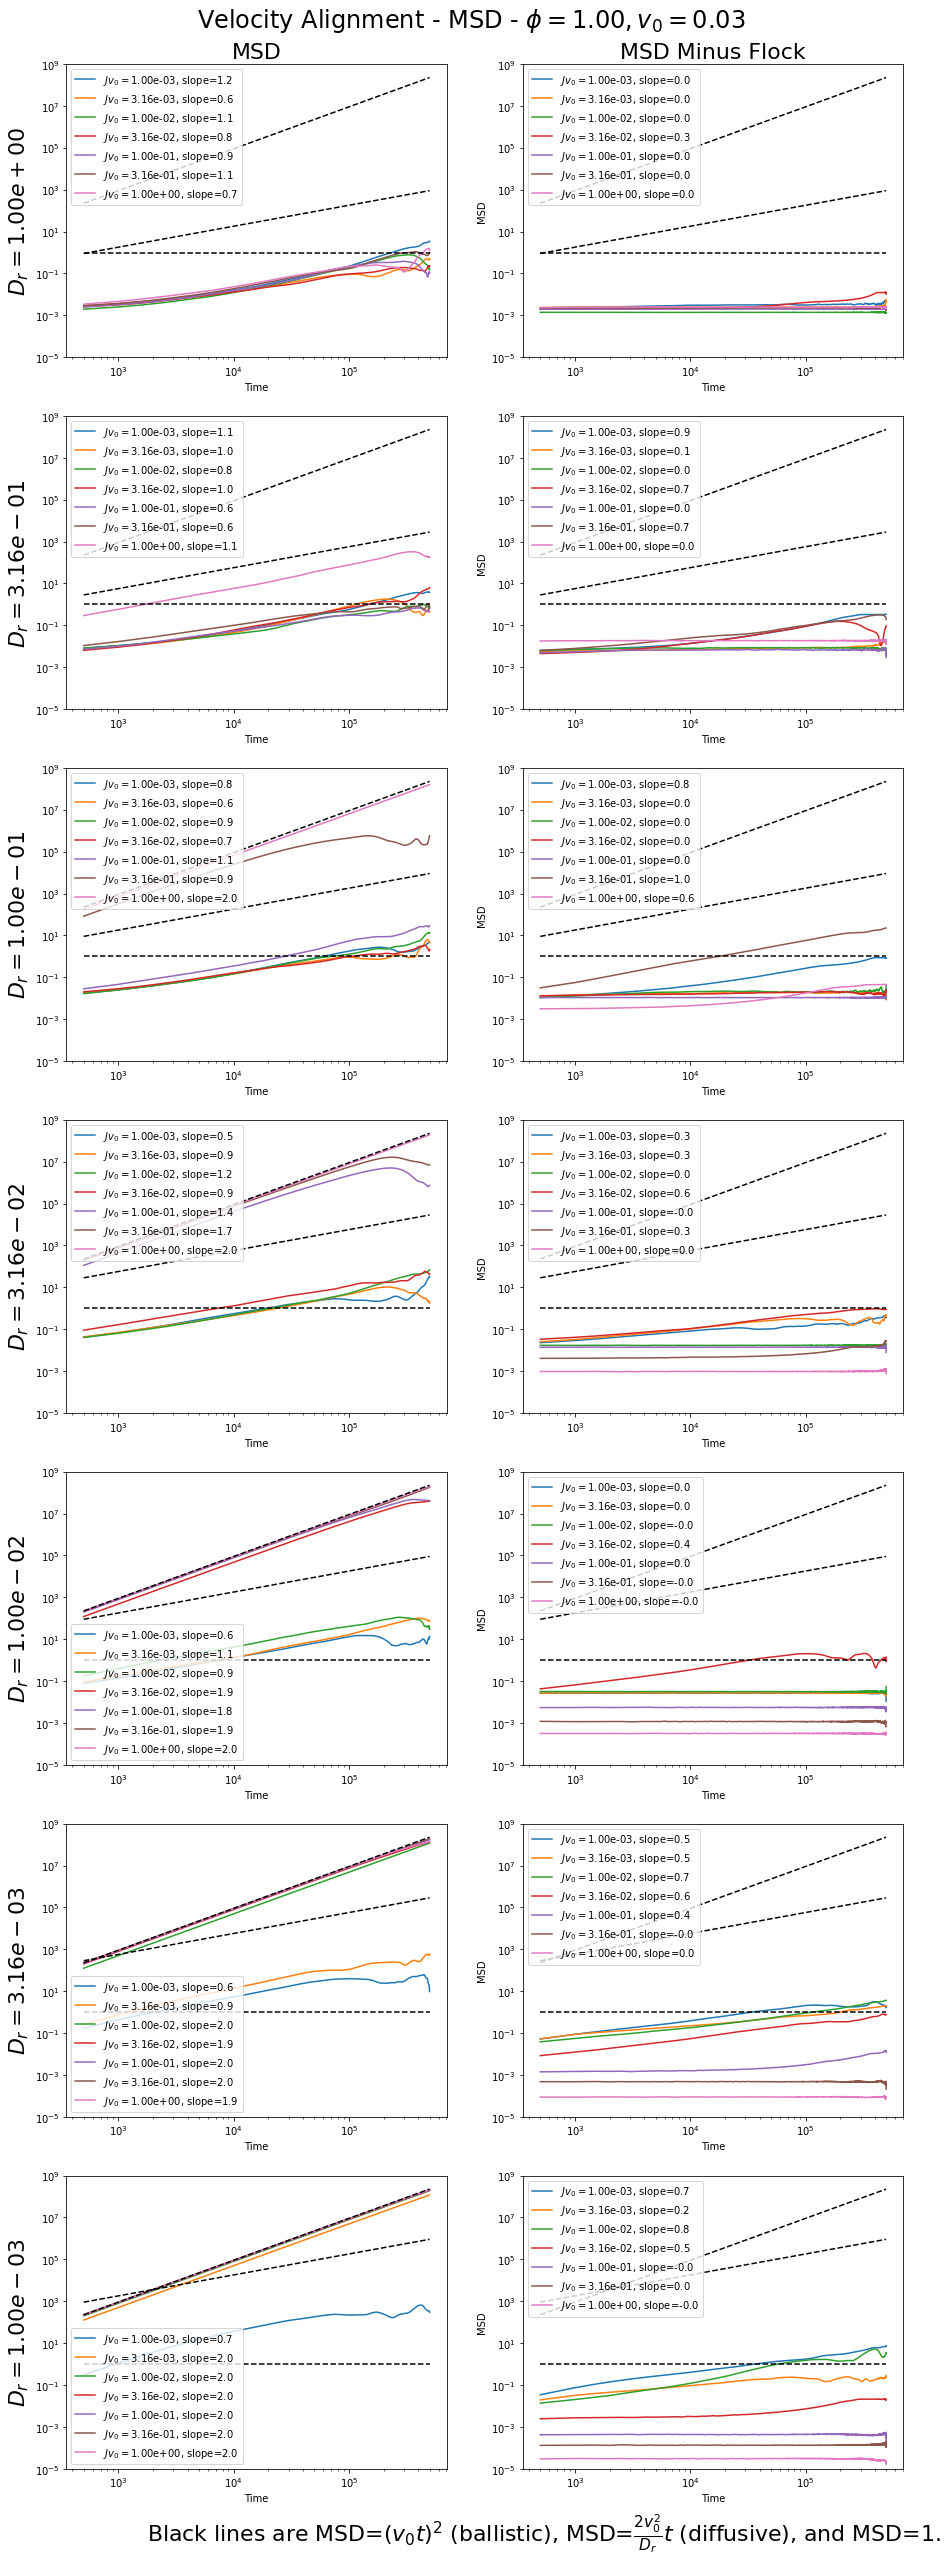

In [4]:
times = np.linspace(0, 5e5, num=1000)[1:]
save_dir = "/home/ryanlopez/Velocity_Align_Vary_Phi_V_Saved_Data2"

phi = 1.0
v0 = 0.03
exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0)
Jv_vals = np.logspace(-3, 0, num=7)
Dr_vals = np.logspace(-3, 0, num=7)
msd_types = ['normal', 'normal_minus_avg']

fig, axs = plt.subplots(len(Dr_vals), len(msd_types), figsize=(15, 40))

# gridspec inside gridspec
for msd_index, msd_type in enumerate(msd_types):
    for Dr_index, Dr in enumerate(Dr_vals):
        for J_index, Jv in enumerate(Jv_vals):
            J = Jv/v0
            run_folder_name = "J=%.4f_and_Dr=%.4f"%(J, Dr)
            analysis_data_dir = os.path.join(save_dir, exp_folder_name, run_folder_name, 'analysis_data')
            if msd_index == 0:
                msd_normal_filename = os.path.join(analysis_data_dir, 'msd_normal.npy')
            elif msd_index == 1:
                msd_normal_filename = os.path.join(analysis_data_dir, 'msd_normal_minus_avg.npy')
            #Plot MSD
            with open(msd_normal_filename, 'rb') as msd_normal_file:
                msd_normal = np.load(msd_normal_file)
            linear_model = LinearRegression().fit(np.log(times)[:,None], np.log(msd_normal)[:,None], sample_weight = np.arange(len(times), 0, -1)**2)
            label = rf'$Jv_0=${Jv:.2e}, slope={linear_model.coef_.item():.1f}'
            axs[-Dr_index-1, msd_index].plot(times, msd_normal, label=label)
        #Plot slope 1 line
        slope_1_line = 2*(v0**2 / Dr)*times
        axs[-Dr_index-1, msd_index].plot(times, slope_1_line, color='black', linestyle='--')
        #Plot slope 2 line
        slope_2_line = v0**2 * times**2
        axs[-Dr_index-1, msd_index].plot(times, slope_2_line, color='black', linestyle='--')
        #Plot MSD = 1 cutoff
        axs[-Dr_index-1, msd_index].plot(times, np.full_like(times, 1), color='black', linestyle='--')
        axs[-Dr_index-1, msd_index].set_xlabel('Time')
        axs[-Dr_index-1, msd_index].set_xscale('log')
        axs[-Dr_index-1, msd_index].set_yscale('log')
        axs[-Dr_index-1, msd_index].set_ylim(1e-5, 1e9)
        if Dr_index == len(Dr_vals)-1:
            if msd_index == 0:
                axs[-Dr_index-1, msd_index].set_title(rf'MSD', fontsize=22)
            elif msd_index == 1:
                axs[-Dr_index-1, msd_index].set_title(rf'MSD Minus Flock', fontsize=22)
        if msd_index == 0:
            axs[-Dr_index-1, msd_index].set_ylabel(rf'$D_r = {Dr:.2e}$', fontsize=22)
        else:
            axs[-Dr_index-1, msd_index].set_ylabel('MSD')
        axs[-Dr_index-1, msd_index].legend()
fig.suptitle(rf'Velocity Alignment - MSD - $\phi={phi:.2f}, v_0={v0:.2f}$', fontsize = 24)
plt.subplots_adjust(top=0.96)
plt.text(0.2, 0.1, r'Black lines are MSD=$(v_0 t)^2$ (ballistic), MSD=$\frac{2v_0^2}{D_r}t$ (diffusive), and MSD=1.', fontsize=22, transform=plt.gcf().transFigure)
save_fig_pdf(os.path.join(save_dir, exp_folder_name, 'phase_diagrams', 'msd_raw_curves.pdf'))
plt.show()

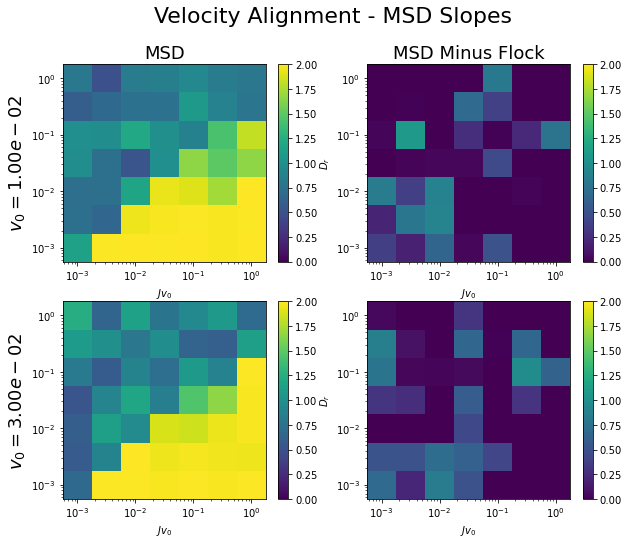

In [31]:
# Make pcolor plots
times = np.linspace(0, 5e5, num=1000)[1:]
save_dir = "/home/ryanlopez/Velocity_Align_Vary_Phi_V_Saved_Data2"

phi = 1.0
v0_vals = [0.01, 0.03]
msd_types = ['normal', 'normal_minus_avg']
Jv_vals = np.logspace(-3, 0, num=7)
Dr_vals = np.logspace(-3, 0, num=7)
xedges = edges_from_centers_log(Jv_vals)
yedges = edges_from_centers_log(Dr_vals)

fig, axs = plt.subplots(len(msd_types), len(v0_vals), figsize=(10, 8))

for v0_index, v0 in enumerate(v0_vals):
    for msd_index, msd_type in enumerate(msd_types):
        #Load / Calculate Data
        statistic_values = []
        for Dr in Dr_vals:
            row_of_values = []
            for Jv in Jv_vals:
                J = Jv/v0
                exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0)
                run_folder_name = "J=%.4f_and_Dr=%.4f"%(J, Dr)
                analysis_data_dir = os.path.join(save_dir, exp_folder_name, run_folder_name, 'analysis_data')
                if msd_type == 'normal':
                    msd_normal_filename = os.path.join(analysis_data_dir, 'msd_normal.npy')
                elif msd_type == 'normal_minus_avg':
                    msd_normal_filename = os.path.join(analysis_data_dir, 'msd_normal_minus_avg.npy')
                with open(msd_normal_filename, 'rb') as msd_normal_file:
                    msd_normal = np.load(msd_normal_file)
                linear_model = LinearRegression().fit(np.log(times)[:,None], np.log(msd_normal)[:,None], sample_weight = np.arange(len(times), 0, -1)**2)
                row_of_values.append(linear_model.coef_.item())
            statistic_values.append(row_of_values)
        statistic_values = np.array(statistic_values)  
        #Make Plot
        axs[v0_index, msd_index].set_xscale('log')
        axs[v0_index, msd_index].set_yscale('log')
        ax = axs[v0_index, msd_index].pcolormesh(xedges, yedges, statistic_values, vmin=0, vmax=2)
        plt.colorbar(ax, ax=axs[v0_index, msd_index])
        axs[v0_index, msd_index].set_xlabel(r'$Jv_0$')
        axs[v0_index, msd_index].set_ylabel(r'$D_r$')
        if v0_index == 0:
            if msd_type == 'normal':
                axs[v0_index, msd_index].set_title('MSD', fontsize=18)
            elif msd_type == 'normal_minus_avg':
                axs[v0_index, msd_index].set_title('MSD Minus Flock', fontsize=18)
        if msd_index == 0:
            axs[v0_index, msd_index].set_ylabel(rf'$v_0={v0:.2e}$', fontsize=18)
plt.suptitle('Velocity Alignment - MSD Slopes', fontsize=22)
save_fig_pdf(os.path.join(save_dir, 'phase_diagrams', 'high_density_pcolor_msd.pdf'))
plt.show()

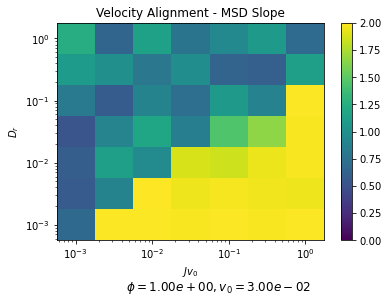

In [2]:
# Make pcolor plots
times = np.linspace(0, 1e5, num=1000)[1:]
save_dir = "/home/ryanlopez/Velocity_Align_Vary_Phi_V_Saved_Data2"

phi = 1.0
v0 = 0.03
exp_folder_name = "phi=%.4f_and_v0=%.4f"%(phi, v0)
msd_type = 'normal'
Jv_vals = np.logspace(-3, 0, num=7)
J_vals = Jv_vals / v0
Dr_vals = np.logspace(-3, 0, num=7)
xedges = edges_from_centers_log(Jv_vals)
yedges = edges_from_centers_log(Dr_vals)

fig, ax = plt.subplots()

#Load / Calculate Data
statistic_values = []
for Dr in Dr_vals:
    row_of_values = []
    for J in J_vals:
        run_folder_name = "J=%.4f_and_Dr=%.4f"%(J, Dr)
        analysis_data_dir = os.path.join(save_dir, exp_folder_name, run_folder_name, 'analysis_data')
        if msd_type == 'normal':
            msd_normal_filename = os.path.join(analysis_data_dir, 'msd_normal.npy')
        elif msd_type == 'normal_minus_avg':
            msd_normal_filename = os.path.join(analysis_data_dir, 'msd_normal_minus_avg.npy')
        with open(msd_normal_filename, 'rb') as msd_normal_file:
            msd_normal = np.load(msd_normal_file)
        linear_model = LinearRegression().fit(np.log(times)[:,None], np.log(msd_normal)[:,None], sample_weight = np.arange(len(times), 0, -1)**2)
        row_of_values.append(linear_model.coef_.item())
    statistic_values.append(row_of_values)
statistic_values = np.array(statistic_values)  
#Make Plot
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Jv_0$')
ax.set_ylabel(r'$D_r$')
plot = ax.pcolormesh(xedges, yedges, statistic_values, vmin=0, vmax=2)
plt.colorbar(plot)
plt.title('Velocity Alignment - MSD Slope')
fig.text(.5, -0.05, rf'$\phi={phi:.2e}, v_0={v0:.2e}$', ha='center', fontsize=12)
save_fig_pdf(os.path.join(save_dir, exp_folder_name, 'phase_diagrams', 'msd_slopes.pdf'))
plt.show()